In [18]:
# Import libraries

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import asyncio
from sklearn import datasets
from tqdm import tqdm
import os
import time

os.environ['ENABLE_ICICLE_GPU'] = 'true'
os.environ['RUST_BACKTRACE']='full'

# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nest_asyncio"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import ezkl
import os
import nest_asyncio

nest_asyncio.apply()

# Task definition

print('Data information')
print('=' * 20)

images, labels = datasets.load_digits(return_X_y=True)
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)
print(f'#samples={len(images)}, image_size={images[0].shape}')

mask = labels % 2 == 1
odd_num_images, odd_num_labels = images[mask], labels[mask]
print(f'#odd_num_images={len(odd_num_images)}')

mask = labels % 2 == 0
even_num_images, even_num_labels = images[mask], labels[mask]
print(f'#even_num_images={len(even_num_images)}')

# Neural network definition
hidden_dim = 256
input_dim = 64
output_dim = 10
num_params = (1 + input_dim) * hidden_dim + (1 + hidden_dim) * output_dim
print(f'num_params={num_params}')


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def get_loss(model, data, labels):
    logits = model(data)
    log_probs = F.log_softmax(logits, dim=1)
    true_log_probs = log_probs.gather(1, labels.view(-1, 1))
    return -true_log_probs.mean()


def get_grad(model, data, labels):
    model.zero_grad()
    loss = get_loss(model, data, labels)
    loss.backward()
    return model.parameters()


def get_acc(logits, labels):
    predicted_labels = logits.argmax(dim=1)
    return (predicted_labels == labels).float().mean().item()


def train(model, x, y, lr=0.003, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = get_loss(model, x, y)
        loss.backward()
        optimizer.step()
    return model


# Test
mlp = MLP()
rand_params = torch.randn(num_params) * 0.01
mlp.fc1.weight.data = rand_params[:hidden_dim * input_dim].view(hidden_dim, input_dim)
mlp.fc1.bias.data = rand_params[hidden_dim * input_dim:hidden_dim * input_dim + hidden_dim]
mlp.fc2.weight.data = rand_params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)
mlp.fc2.bias.data = rand_params[-output_dim:]


Data information
#samples=1797, image_size=torch.Size([64])
#odd_num_images=906
#even_num_images=891
num_params=19210


In [19]:
print(images.shape)
logits = mlp(images)
loss = get_loss(mlp, images, labels)
acc = get_acc(logits, labels)
print(f'Random MLP: loss={loss.item():.4f}, acc={acc:.2f}')

# Train 2 seed MLPs
mlp1 = MLP()
mlp2 = MLP()

mlp1 = train(mlp1, odd_num_images, odd_num_labels)
mlp2 = train(mlp2, even_num_images, even_num_labels)

models = [mlp1, mlp2]
model_names = ['mlp1', 'mlp2']
for model, model_name in zip(models, model_names):
    for x, y, name in zip([odd_num_images, even_num_images, images], [odd_num_labels, even_num_labels, labels], ['d_odd', 'd_even', 'd0-9']):
        logits = model(x)
        acc = get_acc(logits, y)
        print(f'{model_name} acc@{name}={acc:.2f}')
    print('-' * 10)



torch.Size([1797, 64])
Random MLP: loss=2.3017, acc=0.15
mlp1 acc@d_odd=0.93
mlp1 acc@d_even=0.00
mlp1 acc@d0-9=0.47
----------
mlp2 acc@d_odd=0.00
mlp2 acc@d_even=0.99
mlp2 acc@d0-9=0.49
----------


In [24]:
# Evolutionary algorithm merging class and function definitions
#n_iter = 1000
#n_iter = 10
#n_iter = 20
n_iter = 5
mutation_std = 0.01
#pop_size = 512
#num_elite = 4
#pop_size = 10

pop_size = 10
num_elite = 4
seed = 42

class Slerp(nn.Module):
    def __init__(self):
        super(Slerp, self).__init__()

    '''
    def forward(self, val, x, y):
      norm_x = F.normalize(x, dim=-1)
      norm_y = F.normalize(y, dim=-1)
      dot = torch.sum(norm_x * norm_y, dim=-1, keepdim=True)
      omega = torch.acos(torch.clamp(dot, -1.0, 1.0))
      sin_omega = torch.sin(omega)
      scale_x = torch.sin((1.0 - val) * omega) / sin_omega
      scale_y = torch.sin(val * omega) / sin_omega
      lin_scale_x = 1.0 - val
      lin_scale_y = val
      return torch.where(sin_omega > 1e-6, scale_x * x + scale_y * y, lin_scale_x * x + lin_scale_y * y)
    '''
    def forward(self, val, x, y):
        return val*x + (1-val)*y
    

class Mutate(nn.Module):
    def __init__(self, mutation_std):
        super(Mutate, self).__init__()
        self.mutation_std = mutation_std

    def forward(self, rand_num, gene):
        noise = rand_num*self.mutation_std
        return gene + noise

slerp = Slerp()
mutate = Mutate(mutation_std)
RUN_FOLDER = './test_merge_dir/'

from pathlib import Path
Path(RUN_FOLDER).mkdir(parents=True, exist_ok=True) # create directory and any intermediate directories

async def calibrate_operation(op_name, example_inputs, calibration_inputs, input_names, operation_fn, output_names):
    model_path = os.path.join(RUN_FOLDER + op_name + '.onnx')
    compiled_model_path = os.path.join(RUN_FOLDER + op_name + '_network.compiled')
    pk_path = os.path.join(RUN_FOLDER + op_name + '_test.pk')
    vk_path = os.path.join(RUN_FOLDER + op_name + '_test.vk')
    settings_path = os.path.join(RUN_FOLDER + op_name + '_settings.json')
    witness_path = os.path.join(RUN_FOLDER + op_name + '_calibration_witness.json')
    data_path = os.path.join(RUN_FOLDER + op_name + '_calibration_input.json')

    #import ipdb; ipdb.set_trace()
    torch.onnx.export(
        operation_fn,                       # the model/module to be exported
        example_inputs,                 # example inputs
        model_path,                # the file name to save the ONNX model
        export_params=True,          # store the trained parameter weights inside the model file
        opset_version=11,            # the ONNX version to export the model to
        do_constant_folding=True,    # whether to execute constant folding for optimization
        input_names=input_names,  # input names
        output_names=output_names        # output name
    )
    
    py_run_args = ezkl.PyRunArgs()
    py_run_args.input_visibility = "public"
    py_run_args.output_visibility = "public"
    py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

    res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)

    assert res == True

    #data = dict(input_data = [rand_num.detach().numpy().reshape(-1).tolist(), 
    #                          torch.rand(*model.shape).detach().numpy().reshape(-1).tolist()])
    data = dict(input_data = calibration_inputs)
    cal_path = os.path.join(RUN_FOLDER + op_name + "_calibration.json")

    json.dump(data, open(cal_path, 'w'))

    await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    #res = ezkl.get_srs(settings_path)
    res = await ezkl.get_srs(settings_path)    
    #res = await ezkl.get_srs(settings_path, commitment='ipa')
    #res = await ezkl.get_srs(settings_path, commitment=ezkl.PyCommitments.IPA)

    # HERE WE SETUP THE CIRCUIT PARAMS
    # WE GOT KEYS
    # WE GOT CIRCUIT PARAMETERS
    # EVERYTHING ANYONE HAS EVER NEEDED FOR ZK
    
    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
        )
    
    assert res == True


async def prove_operation(op_name, operation_save_name, inputs):
    model_path = os.path.join(RUN_FOLDER + op_name + '.onnx')
    compiled_model_path = os.path.join(RUN_FOLDER + op_name + '_network.compiled')
    pk_path = os.path.join(RUN_FOLDER + op_name + '_test.pk')
    vk_path = os.path.join(RUN_FOLDER + op_name + '_test.vk')
    settings_path = os.path.join(RUN_FOLDER + op_name + '_settings.json')

    witness_path = os.path.join(RUN_FOLDER + op_name + '_input_' + operation_save_name + 'witness.json')
    data_path = os.path.join(RUN_FOLDER + op_name + '_input_' + operation_save_name + '.json')

    # now generate the witness file

    data = dict(input_data = inputs)
    with open(data_path, "w") as f:
        json.dump(data, f)
    res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # GENERATE A PROOF
    proof_path = os.path.join(RUN_FOLDER + operation_save_name + '_test.pf')
    print('Generating ' + proof_path)
    '''
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,

            "single",
        )
    '''
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,

            "for-aggr",
        )
    assert os.path.isfile(proof_path)
    return proof


def crossover(parents, iteration, parent_inds, merge_idx):
    val = torch.rand(1)
    loop = asyncio.get_event_loop()
    #proof = loop.run_until_complete(zk_prove_merge(val, merge_idx, parents[0], parents[1], iteration, parent_inds[0], parent_inds[1]))
    parent_1, parent_2 = parents
    parent_ind_1, parent_ind_2 = parent_inds
    merge_id = 'iter_' + str(iteration) + '_merge_idx_' + str(merge_idx) + '_p1_' + str(parent_ind_1.item()) + '_p2_' + str(parent_ind_2.item())
    inputs = [[val.item()], 
                              parent_1.detach().numpy().reshape(-1).tolist(), 
                              parent_2.detach().numpy().reshape(-1).tolist()]
    proof = loop.run_until_complete(prove_operation('merge', merge_id, inputs))
    #proof = None
    result = slerp(val, parents[0], parents[1])
    return result, proof


def ask(elite_solutions, iteration, mutate_fn):
    parents_indices = torch.randint(0, elite_solutions.shape[0], (pop_size * 2,))
    #ipdb.set_trace()
    parents = elite_solutions[parents_indices].view(pop_size, 2, -1)
    p_inds = parents_indices.view(pop_size, 2)
    #population = torch.stack([crossover(p, iteration, p_inds[i]) for i, p in enumerate(parents)])
    pop_list = []
    proof_list = []
    for merge_idx, p in enumerate(parents):
        merged_model, proof = crossover(p, iteration, p_inds[merge_idx], merge_idx)
        pop_list.append(merged_model)
        proof_list.append(proof)
    population = torch.stack(pop_list)
    pop = []
    mutate_proof_list = []
    loop = asyncio.get_event_loop()
    for merge_idx, g in enumerate(population):
        rand_num = torch.randn(g.shape)
        #proof = loop.run_until_complete(prove_mutate(rand_num, g, merge_idx, iteration))
        mutate_id = 'iter_' + str(iteration) + '_merge_idx_' + str(int(merge_idx)) + '_mutate'
        inputs = [rand_num.detach().numpy().reshape(-1).tolist(), 
                              g.detach().numpy().reshape(-1).tolist()]
        proof = loop.run_until_complete(prove_operation('mutate', mutate_id, inputs))
        pop.append([mutate(rand_num, g) for g in population])
        mutate_proof_list.append(proof)
        
    return population, proof_list, mutate_proof_list, p_inds

def get_flat_params(model):
    return torch.concatenate([p.view(-1) for p in model.parameters()])

def tell(population, scores, proofs):
    top_scores, top_indices = scores.topk(num_elite)
    new_elites = population[top_indices]
    new_elites_proofs = [proofs[idx] for idx in top_indices]
    new_elites[-1] = get_flat_params(mlp1)
    new_elites[-2] = get_flat_params(mlp2)
    return new_elites, new_elites_proofs, top_indices

def reroll_params(flat_params):
    model = MLP()
    
    # Load the model's parameters from the flattened params vector, reshaping the weights
    model.fc1.weight.data = flat_params[:hidden_dim * input_dim].view(hidden_dim, input_dim)

    model.fc1.bias.data = flat_params[(hidden_dim * input_dim):(hidden_dim * input_dim + hidden_dim)]

    model.fc2.weight.data = flat_params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)

    model.fc2.bias.data = flat_params[-output_dim:]
    return model

def eval_params(params, x, y):
    model = reroll_params(params)

    # Reshape the input data to match the expected input size of the model
    x_reshaped = x.view(-1, input_dim)  # Reshape to [batch_size, input_dim]

    logits = model(x_reshaped)  # Pass the reshaped input to the model
    return get_acc(logits, y)
    

In [25]:
# Initialize the elites with seed models
mlp1_param = torch.concatenate([mlp1.state_dict()['fc1.weight'].view(-1), mlp1.state_dict()['fc1.bias'].view(-1), mlp1.state_dict()['fc2.weight'].view(-1), mlp1.state_dict()['fc2.bias'].view(-1)])
mlp2_param = torch.concatenate([mlp2.state_dict()['fc1.weight'].view(-1), mlp2.state_dict()['fc1.bias'].view(-1), mlp2.state_dict()['fc2.weight'].view(-1), mlp2.state_dict()['fc2.bias'].view(-1)])
elites = torch.stack([mlp1_param, mlp2_param])
#elites = elites[torch.randint(0, 2, (num_elite,))]

# calibrate circuit
val = torch.rand(1)
loop = asyncio.get_event_loop()
calibrate_start = time.time()
#verified = loop.run_until_complete(calibrate_circuit(val, mlp1_param, mlp2_param))

op_name = 'merge'
example_inputs = (val, mlp1_param, mlp2_param)
calibration_inputs = [[val.item()], 
                              torch.rand(*mlp1_param.shape).detach().numpy().reshape(-1).tolist(), 
                              torch.rand(*mlp2_param.shape).detach().numpy().reshape(-1).tolist()]
input_names = ['val', 'parent_1', 'parent_2']  # input names
operation_fn = slerp
output_names = ['merged_weights']        # output name

loop.run_until_complete(calibrate_operation(op_name, example_inputs, calibration_inputs, input_names, operation_fn, output_names))

calibrate_end = time.time()
calibration_duration = calibrate_end - calibrate_start
print('Calibration duration: ' + str(calibration_duration))

Using 2 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.


 <------------- Numerical Fidelity Report (input_scale: 13, param_scale: 13, scale_input_multiplier: 10) ------------->

+-------------------+-----------------+--------------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error        | median_error    | max_error    | min_error      | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+-------------------+-----------------+--------------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.000000057752082 | -0.000015258789 | 0.0000744462 | -0.00007261336 | 0.00002361205  | 0.000015258789   | 0.0000744462  | 0        

Calibration duration: 11.79940414428711


In [26]:
# mutate calibration

mutate_calibrate_start = time.time()
rand_num = torch.randn(mlp1_param.shape)

#verified = loop.run_until_complete(calibrate_mutate(rand_num, mlp1_param, mutate))
op_name = 'mutate'
example_inputs = (rand_num, mlp1_param)
calibration_inputs = [rand_num.detach().numpy().reshape(-1).tolist(), 
                              torch.rand(*mlp1_param.shape).detach().numpy().reshape(-1).tolist()]
input_names = ['rand_num', 'model']
operation_fn = mutate
output_names = ['mutated_weights']
loop.run_until_complete(calibrate_operation(op_name, example_inputs, calibration_inputs, input_names, operation_fn, output_names))

mutate_calibrate_end = time.time()
mutate_calibration_duration = mutate_calibrate_end - mutate_calibrate_start
print('Calibration duration: ' + str(calibration_duration))



 <------------- Numerical Fidelity Report (input_scale: 13, param_scale: 13, scale_input_multiplier: 10) ------------->

+-------------------+---------------+----------------+---------------+----------------+------------------+----------------+---------------+--------------------+--------------------+------------------------+
| mean_error        | median_error  | max_error      | min_error     | mean_abs_error | median_abs_error | max_abs_error  | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+-------------------+---------------+----------------+---------------+----------------+------------------+----------------+---------------+--------------------+--------------------+------------------------+
| -0.00000036103515 | 0.00002476573 | 0.000088870525 | -0.0000859499 | 0.00003112732  | 0.00002476573    | 0.000088870525 | 0             | 0.0000000013297742 | 0.0007778963       | 0.0011549033           |
+-------------------+---------------+------------

Calibration duration: 11.79940414428711


  0%|                                                                                                      | 0/5 [00:00<?, ?it/s]

Generating ./test_merge_dir/iter_0_merge_idx_0_p1_0_p2_0_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_1_p1_0_p2_1_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_2_p1_0_p2_1_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_3_p1_0_p2_0_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_4_p1_0_p2_0_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_5_p1_1_p2_0_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_6_p1_0_p2_0_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_7_p1_0_p2_1_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_8_p1_0_p2_1_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_9_p1_1_p2_0_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_0_mutate_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_1_mutate_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_2_mutate_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_3_mutate_test.pf
Generating ./test_merge_dir/iter_0_merge_idx_4_mutate_test.pf
Generating ./test_merge_dir/iter_0_merge

 20%|██████████████████▊                                                                           | 1/5 [00:47<03:10, 47.57s/it]

Generating ./test_merge_dir/iter_0_merge_idx_9_mutate_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_0_p1_0_p2_1_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_1_p1_3_p2_2_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_2_p1_2_p2_3_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_3_p1_3_p2_2_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_4_p1_1_p2_1_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_5_p1_1_p2_1_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_6_p1_1_p2_0_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_7_p1_0_p2_2_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_8_p1_0_p2_1_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_9_p1_1_p2_2_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_0_mutate_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_1_mutate_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_2_mutate_test.pf
Generating ./test_merge_dir/iter_1_merge_idx_3_mutate_test.pf
Generating ./test_merge_dir/iter_1_merge

 40%|█████████████████████████████████████▌                                                        | 2/5 [01:35<02:22, 47.56s/it]

Generating ./test_merge_dir/iter_1_merge_idx_9_mutate_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_0_p1_2_p2_3_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_1_p1_1_p2_0_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_2_p1_2_p2_0_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_3_p1_3_p2_3_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_4_p1_3_p2_2_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_5_p1_0_p2_1_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_6_p1_2_p2_0_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_7_p1_3_p2_3_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_8_p1_0_p2_0_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_9_p1_3_p2_3_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_0_mutate_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_1_mutate_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_2_mutate_test.pf
Generating ./test_merge_dir/iter_2_merge_idx_3_mutate_test.pf
Generating ./test_merge_dir/iter_2_merge

 60%|████████████████████████████████████████████████████████▍                                     | 3/5 [02:22<01:34, 47.49s/it]

Generating ./test_merge_dir/iter_2_merge_idx_9_mutate_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_0_p1_1_p2_2_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_1_p1_3_p2_3_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_2_p1_1_p2_0_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_3_p1_1_p2_3_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_4_p1_0_p2_1_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_5_p1_1_p2_0_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_6_p1_2_p2_2_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_7_p1_3_p2_1_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_8_p1_2_p2_3_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_9_p1_2_p2_1_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_0_mutate_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_1_mutate_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_2_mutate_test.pf
Generating ./test_merge_dir/iter_3_merge_idx_3_mutate_test.pf
Generating ./test_merge_dir/iter_3_merge

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 4/5 [03:10<00:47, 47.60s/it]

Generating ./test_merge_dir/iter_3_merge_idx_9_mutate_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_0_p1_0_p2_3_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_1_p1_3_p2_0_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_2_p1_0_p2_3_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_3_p1_3_p2_1_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_4_p1_2_p2_2_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_5_p1_1_p2_1_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_6_p1_0_p2_2_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_7_p1_3_p2_0_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_8_p1_3_p2_0_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_9_p1_0_p2_2_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_0_mutate_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_1_mutate_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_2_mutate_test.pf
Generating ./test_merge_dir/iter_4_merge_idx_3_mutate_test.pf
Generating ./test_merge_dir/iter_4_merge

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:57<00:00, 47.54s/it]

Generating ./test_merge_dir/iter_4_merge_idx_9_mutate_test.pf
Evolutionary model merging with proof generation duration: 237.6854259967804


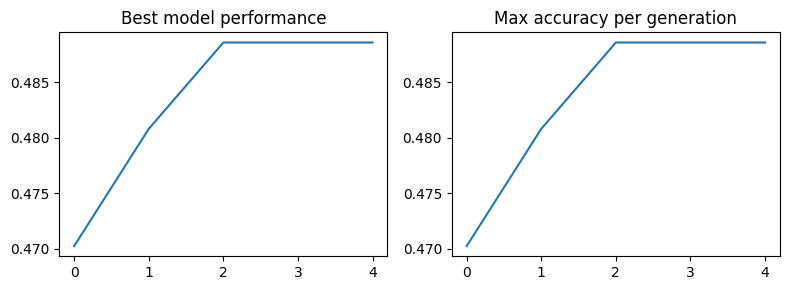

In [27]:
# Optimization loop
acc_max = []
merge_idx_and_p_inds = []

top_model_history = [] # list of parents of top model
all_model_histories = [] # list of lists of parents of current population of models

start_time = time.time()
for i in tqdm(range(n_iter)):
    population, proofs, mutate_proofs, p_inds = ask(elites, i, mutate)
    p_inds_w_merge_idx = torch.concatenate([torch.arange(pop_size).reshape(-1,1), p_inds], dim=1) # concatenated iteration number and all parent indices
    merge_idx_and_p_inds.append(p_inds_w_merge_idx)
    #print(population.shape)
    scores = torch.tensor([eval_params(p, images, labels) for p in population])
    #print('score values')
    #print(scores)
    #elites = tell(elites, scores)
    elites, new_elites_proofs, top_inds = tell(population, scores, proofs)
    acc_max.append(scores.max().item())

merge_idx_and_p_inds = torch.stack(merge_idx_and_p_inds)
best_ind = top_inds[0]

end_time = time.time()
duration = end_time - start_time
print('Evolutionary model merging with proof generation duration: ' + str(duration))
# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
ax.plot(np.maximum.accumulate(acc_max))
ax.set_title('Best model performance')
ax = axes[1]
ax.plot(acc_max)
ax.set_title('Max accuracy per generation')

plt.tight_layout()
plt.show()

In [30]:
print(merge_idx_and_p_inds)
async def verify_proof(op_name, operation_save_name):
    proof_path = os.path.join(RUN_FOLDER + operation_save_name + '_test.pf')
    settings_path = os.path.join(RUN_FOLDER + op_name + '_settings.json')
    #vk_path = os.path.join(RUN_FOLDER + merge_id + '_test.vk')
    vk_path = os.path.join(RUN_FOLDER + op_name + '_test.vk')
    print('Verifying ' + proof_path)
    #print(proof_path)
    #print(settings_path)
    #print(vk_path)
    assert os.path.isfile(proof_path)
    assert os.path.isfile(settings_path)
    assert os.path.isfile(vk_path)
    res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path
    )
    assert res == True
    print(op_name + " verified")
    return res
    
async def verify_proofs(merge_id, mutate_id):
    #res = await verify_proof('merge', merge_id)
    #res = await verify_proof('mutate', mutate_id)
    res = await asyncio.gather(verify_proof('merge', merge_id), verify_proof('mutate', mutate_id))
    return res
    

async def aggregate_merge_and_mutate(merge_id, mutate_id):
    merge_proof_path = os.path.join(RUN_FOLDER + merge_id + '_test.pf')
    mutate_proof_path = os.path.join(RUN_FOLDER + mutate_id + '_test.pf')
    print('Aggregating ' + merge_proof_path + ' and ' + mutate_proof_path + ' ...')
    num_logrows = 21
    res = await ezkl.get_srs(settings_path=None, logrows=num_logrows, commitment=ezkl.PyCommitments.KZG)
    #res = ezkl.mock_aggregate([merge_proof_path, mutate_proof_path], num_logrows)
    res = ezkl.mock_aggregate([merge_proof_path], num_logrows)
    import ipdb; ipdb.set_trace()
    assert res == True

    aggregate_proof_path = os.path.join('aggr.pf')
    aggregate_vk_path = os.path.join('aggr.vk')
    aggregate_pk_path = os.path.join('aggr.pk')
    # Setup the vk and pk for aggregate
    res = ezkl.setup_aggregate(
        [merge_proof_path, mutate_proof_path],
        aggregate_vk_path,
        aggregate_pk_path,
        num_logrows
    )
    aggr_proof = ezkl.aggregate(
        [merge_proof_path, mutate_proof_path],
        aggregate_proof_path,
        aggregate_pk_path,
        "evm",
        num_logrows,
        "safe"
    )
    
    assert os.path.isfile(aggregate_proof_path)
    
    assert os.path.isfile(aggregate_vk_path)
    assert os.path.isfile(aggregate_pk_path)
    # Check if the proof is valid
    res = ezkl.verify_aggr(
        aggregate_proof_path,
        aggregate_vk_path,
        num_logrows,
    )
    assert res == True
    print('verified aggregate')

    return aggr_proof


async def verify_all_proofs(merge_idx_and_p_inds):
    merge_ids = []
    mutate_ids = []
    for iteration, merge_list in enumerate(merge_idx_and_p_inds):
        for merge in merge_list:
            merge_id = 'iter_' + str(iteration) + '_merge_idx_' + str(int(merge[0])) + '_p1_' + str(int(merge[1])) + '_p2_' + str(int(merge[2]))
            merge_ids.append(merge_id)
            mutate_id = 'iter_' + str(iteration) + '_merge_idx_' + str(int(merge[0])) + '_mutate'
            mutate_ids.append(mutate_id)
    await asyncio.gather(*(verify_proofs(merge_id, mutate_id) for (merge_id, mutate_id) in zip(merge_ids, mutate_ids)))


async def verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind):
    # given the ending best performing model, get each proof in the tree of proofs that is necessary to prove the parent models
    parents_to_verify = [tuple(merge_idx_and_p_inds[-1][best_ind].tolist())] # get the parent indices of the best model of in the last iteration
    merge_ids = set()
    mutate_ids = set()
    all_ids = set()
    for iteration in reversed(range(len(merge_idx_and_p_inds))):
        # verify current parents
        new_parents = []
        for parents in parents_to_verify:
            print(parents_to_verify)
            merge_idx = parents[0]
            print('Model ' + str(merge_idx) + ' from iteration ' + str(iteration) + ' has parents ' + str(int(parents[1])) + ' and ' + str(int(parents[2])) + ' from iteration ' + str(iteration-1))
            merge_id = 'iter_' + str(int(iteration)) + '_merge_idx_' + str(int(merge_idx)) + '_p1_' + str(int(parents[1])) + '_p2_' + str(int(parents[2]))
            grandparents_p1 = tuple(merge_idx_and_p_inds[iteration-1][parents[1]].tolist())
            grandparents_p2 = tuple(merge_idx_and_p_inds[iteration-1][parents[2]].tolist())
            new_parents.append(grandparents_p1)
            new_parents.append(grandparents_p2)
            
            mutate_id = 'iter_' + str(iteration) + '_merge_idx_' + str(int(merge_idx)) + '_mutate'
            merge_ids.add(merge_id)
            mutate_ids.add(mutate_id)
            all_ids.add((merge_id, mutate_id))
            #print('The parents of ' + merge_id + ' are ' + 'iter_' + str(int(iteration-1)) + '_merge_idx_' + str(int(parents[0])) + '_p1_' + str(int(new_parents[0][1])) + '_p2_' + str(int(new_parents[0][2])) + ' and ' \
            #    'iter_' + str(int(iteration-1)) + '_merge_idx_' + str(int(parents[1])) + '_p1_' + str(int(new_parents[1][1])) + '_p2_' + str(int(new_parents[1][2])))
        print('Iteration ' + str(iteration))
        parents_to_verify = set(new_parents) # don't include the same parents twice
        print(parents_to_verify)
        print('number of parents to verify ' + str(len(parents_to_verify)))

    #return await asyncio.gather(*(verify_proofs(merge_id) for merge_id in merge_ids))
    #await asyncio.gather(*(aggregate_merge_and_mutate(merge_id, mutate_id) for (merge_id, mutate_id) in all_ids))
    #await aggregate_merge_and_mutate(*(list(all_ids)[0]))
    return await asyncio.gather(*(verify_proofs(merge_id, mutate_id) for (merge_id, mutate_id) in all_ids))

tensor([[[0, 0, 0],
         [1, 0, 1],
         [2, 0, 1],
         [3, 0, 0],
         [4, 0, 0],
         [5, 1, 0],
         [6, 0, 0],
         [7, 0, 1],
         [8, 0, 1],
         [9, 1, 0]],

        [[0, 0, 1],
         [1, 3, 2],
         [2, 2, 3],
         [3, 3, 2],
         [4, 1, 1],
         [5, 1, 1],
         [6, 1, 0],
         [7, 0, 2],
         [8, 0, 1],
         [9, 1, 2]],

        [[0, 2, 3],
         [1, 1, 0],
         [2, 2, 0],
         [3, 3, 3],
         [4, 3, 2],
         [5, 0, 1],
         [6, 2, 0],
         [7, 3, 3],
         [8, 0, 0],
         [9, 3, 3]],

        [[0, 1, 2],
         [1, 3, 3],
         [2, 1, 0],
         [3, 1, 3],
         [4, 0, 1],
         [5, 1, 0],
         [6, 2, 2],
         [7, 3, 1],
         [8, 2, 3],
         [9, 2, 1]],

        [[0, 0, 3],
         [1, 3, 0],
         [2, 0, 3],
         [3, 3, 1],
         [4, 2, 2],
         [5, 1, 1],
         [6, 0, 2],
         [7, 3, 0],
         [8, 3, 0],
         [9,

In [31]:
verify_start = time.time()
best_ind = top_inds[0]
await verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind)
verify_end = time.time()

verify_duration = verify_end - verify_start
print('Proof verification duration (best path):' + str(verify_duration))

[(6, 0, 2)]
Model 6 from iteration 4 has parents 0 and 2 from iteration 3
Iteration 4
{(0, 1, 2), (2, 1, 0)}
number of parents to verify 2
{(0, 1, 2), (2, 1, 0)}
Model 0 from iteration 3 has parents 1 and 2 from iteration 2
{(0, 1, 2), (2, 1, 0)}
Model 2 from iteration 3 has parents 1 and 0 from iteration 2
Iteration 3
{(0, 2, 3), (1, 1, 0), (2, 2, 0)}
number of parents to verify 3
{(0, 2, 3), (1, 1, 0), (2, 2, 0)}
Model 0 from iteration 2 has parents 2 and 3 from iteration 1
{(0, 2, 3), (1, 1, 0), (2, 2, 0)}
Model 1 from iteration 2 has parents 1 and 0 from iteration 1
{(0, 2, 3), (1, 1, 0), (2, 2, 0)}
Model 2 from iteration 2 has parents 2 and 0 from iteration 1
Iteration 2
{(2, 2, 3), (1, 3, 2), (3, 3, 2), (0, 0, 1)}
number of parents to verify 4
{(2, 2, 3), (1, 3, 2), (3, 3, 2), (0, 0, 1)}
Model 2 from iteration 1 has parents 2 and 3 from iteration 0
{(2, 2, 3), (1, 3, 2), (3, 3, 2), (0, 0, 1)}
Model 1 from iteration 1 has parents 3 and 2 from iteration 0
{(2, 2, 3), (1, 3, 2), (3,

In [32]:
verify_start = time.time()
await verify_all_proofs(merge_idx_and_p_inds)
#best_ind = top_inds[0]
#await verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind)
verify_end = time.time()

verify_duration = verify_end - verify_start
print('Proof verification duration (all):' + str(verify_duration))

Verifying ./test_merge_dir/iter_0_merge_idx_0_p1_0_p2_0_test.pf
merge verified
Verifying ./test_merge_dir/iter_0_merge_idx_0_mutate_test.pf
mutate verified
Verifying ./test_merge_dir/iter_0_merge_idx_1_p1_0_p2_1_test.pf
merge verified
Verifying ./test_merge_dir/iter_0_merge_idx_1_mutate_test.pf
mutate verified
Verifying ./test_merge_dir/iter_0_merge_idx_2_p1_0_p2_1_test.pf
merge verified
Verifying ./test_merge_dir/iter_0_merge_idx_2_mutate_test.pf
mutate verified
Verifying ./test_merge_dir/iter_0_merge_idx_3_p1_0_p2_0_test.pf
merge verified
Verifying ./test_merge_dir/iter_0_merge_idx_3_mutate_test.pf
mutate verified
Verifying ./test_merge_dir/iter_0_merge_idx_4_p1_0_p2_0_test.pf
merge verified
Verifying ./test_merge_dir/iter_0_merge_idx_4_mutate_test.pf
mutate verified
Verifying ./test_merge_dir/iter_0_merge_idx_5_p1_1_p2_0_test.pf
merge verified
Verifying ./test_merge_dir/iter_0_merge_idx_5_mutate_test.pf
mutate verified
Verifying ./test_merge_dir/iter_0_merge_idx_6_p1_0_p2_0_test.pf


In [11]:
## EVALUATION
batch_size = 3

class EvaluateModel(nn.Module):

    def __init__(self, model):
        super().__init__()
        # self.X = X
        self.model = model
    
    def forward(self, X, y):
        logits = self.model(X)
        return get_acc(logits, y)

def get_acc(logits, labels):
    predicted_labels = logits.argmax(dim=-1)
    return (predicted_labels == labels).float().mean()

best_model = reroll_params(elites[0])
eval_mod = EvaluateModel(best_model)
RUN_FOLDER = "./test_eval_dir/"

from pathlib import Path
Path(RUN_FOLDER).mkdir(parents=True, exist_ok=True) # create directory and any intermediate directories


images = images[:batch_size, :]
labels = labels[:batch_size]
print(images.shape)
print(labels.shape)
op_name = 'eval'
example_inputs = (images, labels)
calibration_inputs = [images.detach().numpy().reshape(-1).tolist(),
                       labels.detach().numpy().reshape(-1).tolist()]
input_names = ['images', 'labels']
output_names = ['acc']

loop = asyncio.get_event_loop()
loop.run_until_complete(calibrate_operation(op_name, example_inputs, calibration_inputs, input_names, eval_mod, output_names))


Using 4 columns for non-linearity table.
Using 4 columns for non-linearity table.
Using 4 columns for non-linearity table.
Using 8 columns for non-linearity table.
Using 8 columns for non-linearity table.
Using 8 columns for non-linearity table.


torch.Size([3, 64])
torch.Size([3])


Using 4 columns for non-linearity table.
Using 4 columns for non-linearity table.
Using 8 columns for non-linearity table.
Using 8 columns for non-linearity table.


 <------------- Numerical Fidelity Report (input_scale: 11, param_scale: 11, scale_input_multiplier: 1) ------------->

+----------------+----------------+----------------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error     | median_error   | max_error      | min_error      | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+----------------+----------------+----------------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| -0.00016275048 | -0.00016275048 | -0.00016275048 | -0.00016275048 | 0.00016275048  | 0.0001627504

In [82]:
print(images.shape)
print(labels.shape)

torch.Size([3, 64])
torch.Size([3])


In [83]:
images, labels = datasets.load_digits(return_X_y=True)
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)
print(images.shape)
print(labels.shape)

total_chunks = images.shape[0] // batch_size # assumes divisible

import tqdm
total_chunks = 4 # for testing
op_name = 'eval'
names_and_inputs_list = []
for i in tqdm.tqdm(range(total_chunks)):
    operation_save_name = f'eval_batch_{i}'
    inputs = [images[i * batch_size: (i + 1) * batch_size, :].detach().numpy().reshape(-1).tolist(),
                        labels[i * batch_size: (i + 1) * batch_size].detach().numpy().reshape(-1).tolist()]
    names_and_inputs_list.append((operation_save_name, inputs))
    #res = await prove_operation(op_name, operation_save_name, inputs)
res = await asyncio.gather(*(prove_operation(op_name, operation_save_name, inputs) for (operation_save_name, inputs) in names_and_inputs_list))
# gather parallelizes this


torch.Size([1797, 64])
torch.Size([1797])


100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:44<00:00, 11.19s/it]


In [84]:
start_verify = time.time()
op_name = 'eval'
for i in range(total_chunks):
    '''
    witness_path = os.path.join(RUN_FOLDER + f'witness_{i}.json')
    proof_path = os.path.join(RUN_FOLDER + f"test_proof_{i}.pf")
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path
        )
    '''
    operation_save_name = f'eval_batch_{i}'
    res = await verify_proof(op_name, operation_save_name)
    assert res == True
    print("verified")
    
end_verify = time.time()
verify_dur = end_verify - start_verify
print('Total verify duration: ' + str(verify_dur))

eval verified
verified
eval verified
verified
eval verified
verified
eval verified
verified
Total verify duration: 0.0973045825958252
